# Using Machine Learning Tools 2024, Assignment 3

## Sign Language Image Classification using Deep Learning

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import string

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import train_test_split

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import keras_tuner as kt

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load data

In [2]:
# Load the data
data_train = pd.read_csv('./Assignment3_UMLT_2024/sign_mnist_train.csv')
data_test = pd.read_csv('./Assignment3_UMLT_2024/sign_mnist_test.csv')

## 2. Prepare data

In [3]:
# Separate labels and pixel values
y_train = data_train['label'].values
X_train = data_train.drop('label', axis=1).values
y_test = data_test['label'].values
X_test = data_test.drop('label', axis=1).values

In [4]:
# Check the unique values in the labels
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

There is a missing value in labels

In [5]:
# Define function to shift labels from 10-24 to 9-23
def map_labels(labels):

    alphabet = list(string.ascii_uppercase)
    int_to_alphabet = {i: alphabet[i] for i in range(26)}
  
    letter_labels = [int_to_alphabet[i] for i in labels] # Map labels to corresponding letters
    
    unique_labels = np.unique(letter_labels)
    letter_mapping = {unique_labels[i]: i for i in range(len(unique_labels))}
   
    num_labels = [letter_mapping[int_to_alphabet[i]] for i in labels] # Map the given letters to their corresponding integers

    return letter_labels, num_labels

In [6]:
# Reshape the pixel values into 32x32 images
X_train = X_train.reshape(-1, 32, 32, 1)
X_test = X_test.reshape(-1, 32, 32, 1)

# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

# Convert labels from numbers to alphabet characters and shift them from 10-24 to 9-23
y_train_alphabet, y_train_nums = map_labels(y_train)
y_val_alphabet, y_val_nums = map_labels(y_val)
y_test_alphabet, y_test_nums = map_labels(y_test)

# Convert labels from numbers to alphabet characters
y_train_cat = to_categorical(y_train_nums, 24)
y_val_cat = to_categorical(y_val_nums, 24)
y_test_cat = to_categorical(y_test_nums, 24)

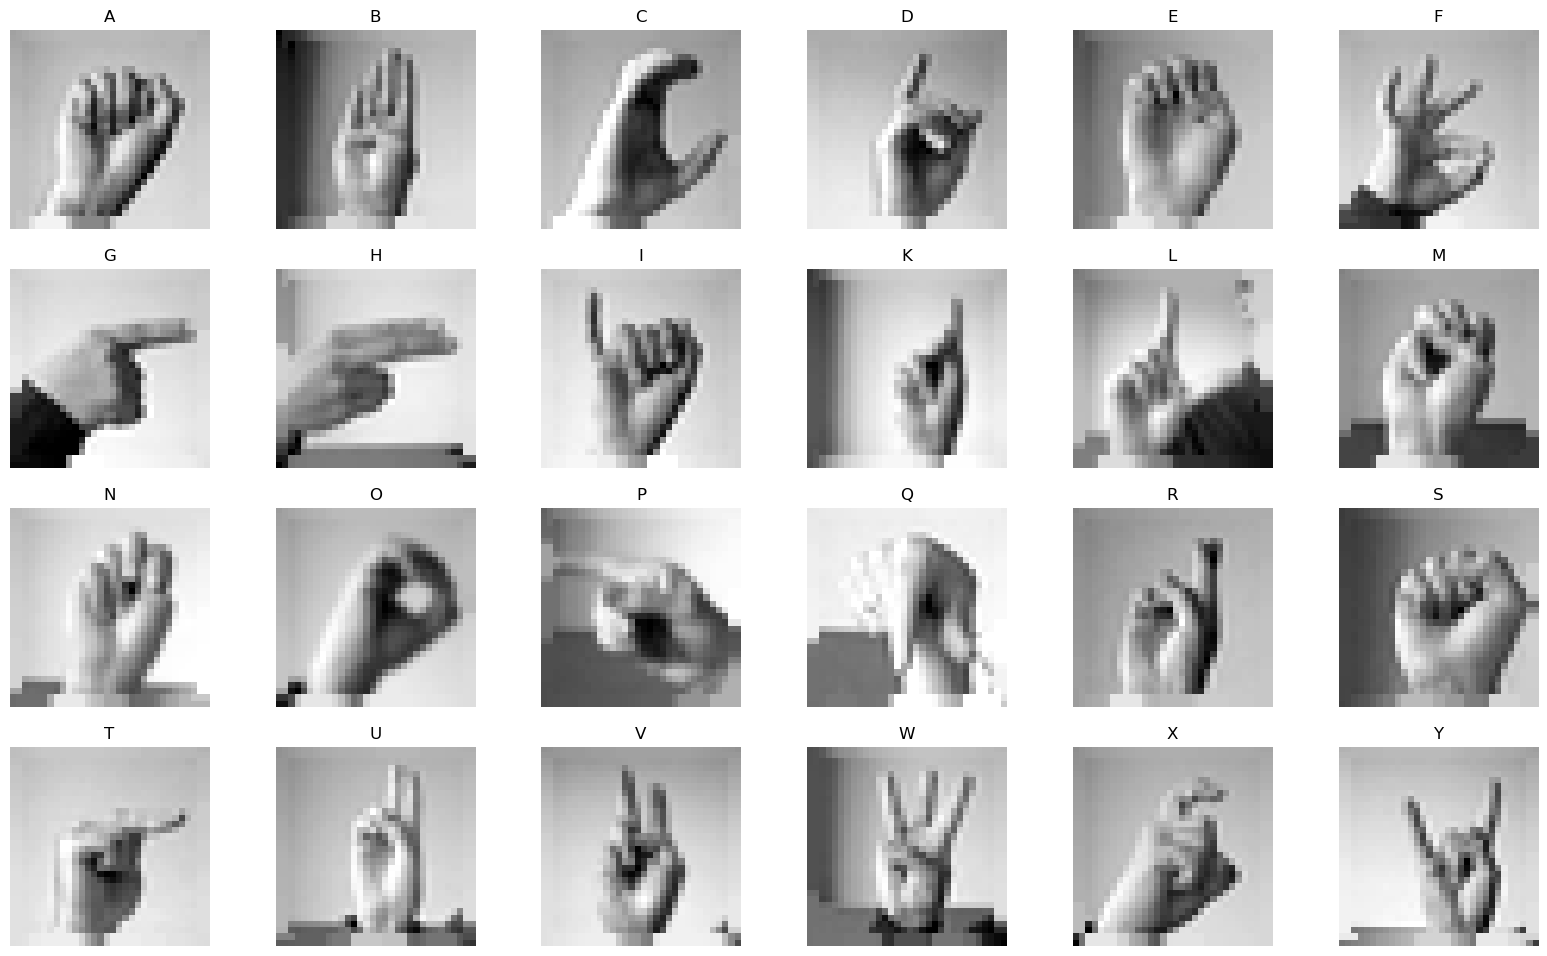

In [7]:
# Display a sample of each letter
unique_labels = np.unique(y_val_nums)
plt.figure(figsize=(20, 15))
for i, label in enumerate(unique_labels):
    idx = np.where(y_val_nums == label)[0][0]
    plt.subplot(5, 6, i + 1)
    plt.imshow(X_val[idx].reshape(32, 32), cmap='gray')
    plt.title(y_val_alphabet[idx], fontsize=12)
    plt.grid(False)
    plt.axis('off')
plt.show()

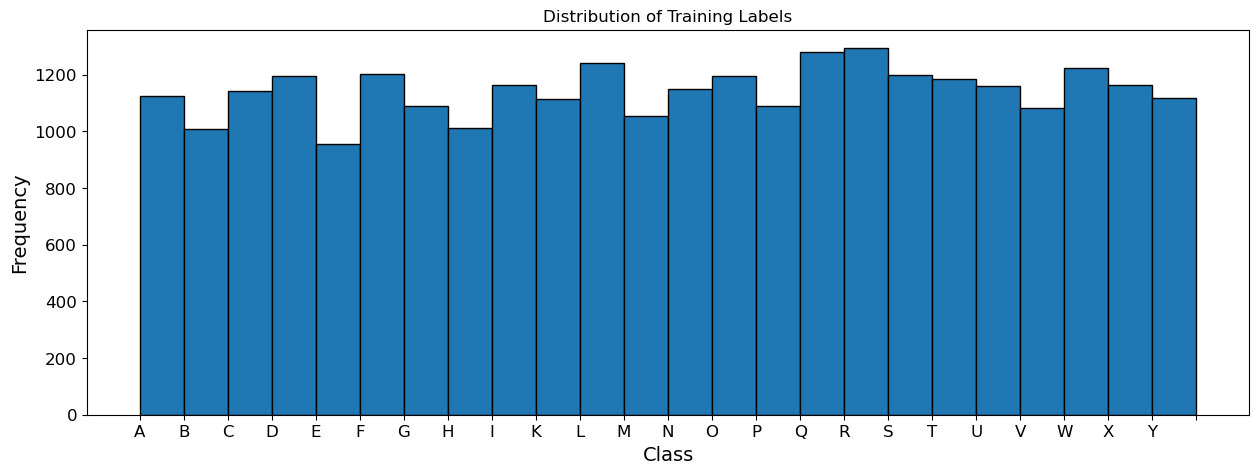

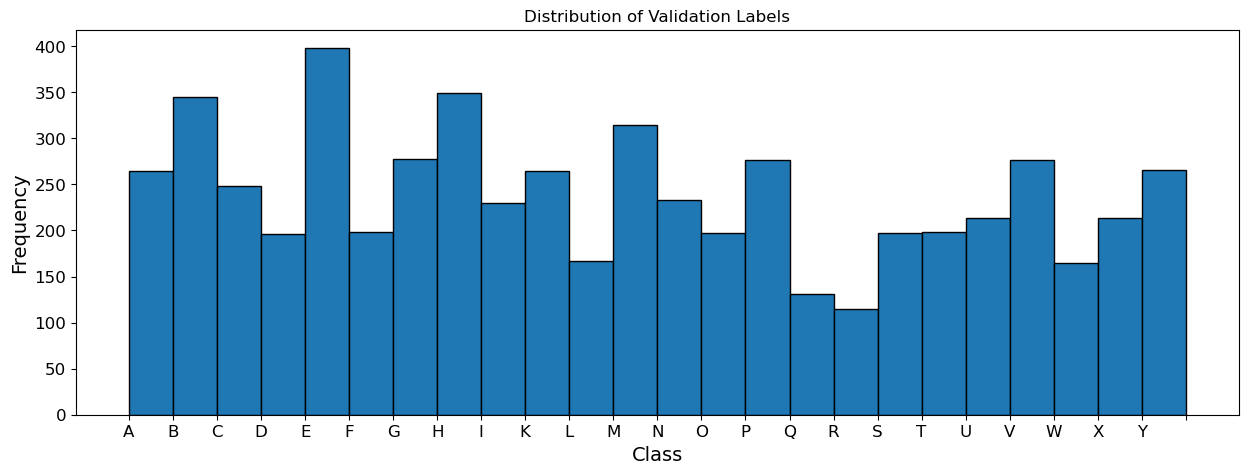

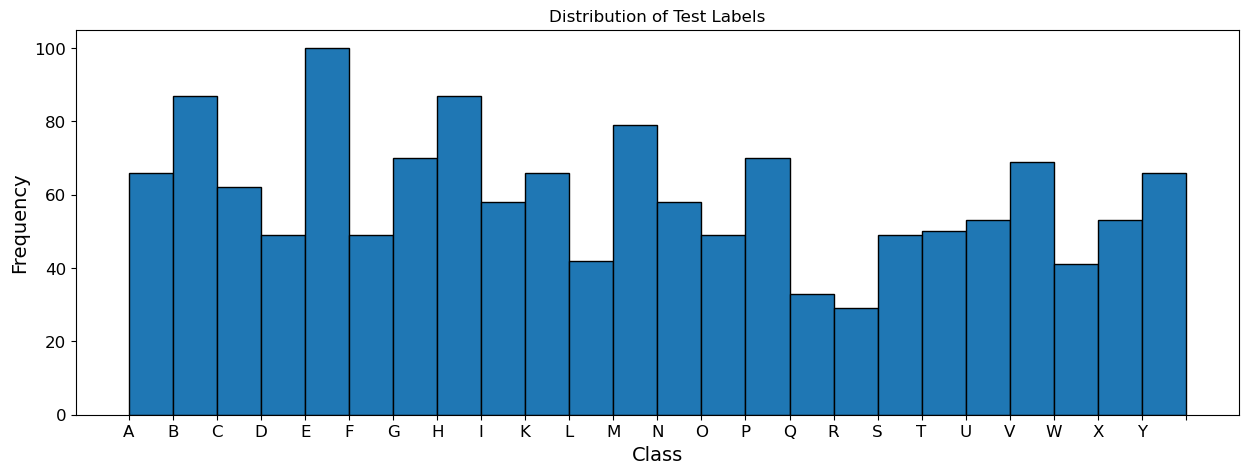

In [8]:
# Define your datasets and corresponding titles
labels = [
    (y_train_alphabet, 'Distribution of Training Labels'),
    (y_val_alphabet, 'Distribution of Validation Labels'),
    (y_test_alphabet, 'Distribution of Test Labels')
]

# Plot distribution of labels
for data, title in labels:
    plt.figure(figsize=(15, 5))
    plt.hist(sorted(data), bins=range(25), edgecolor='black')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(range(25)) 
    plt.show()

## 3. Prepare models

Implement 2 baseline models for densly connected (3 dense layers) and CNN (2 convolutional layers) and evaluate their learning curves.

The number of units in dense layers and the number of filters in convolutional layers are chosen based on a multiple of half of the output quantity (12).

### 3.1 Dense model

Dense model has 3 simple dense layers with 128, 64 and 24 units in that order.

In [9]:
# Define the baseline dense model
def build_baseline_dense_model():
    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(24, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# Build the baseline dense model
baseline_dense_model = build_baseline_dense_model()

# Summary of the baseline dense model
baseline_dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
Total params: 141,016
Trainable params: 141,016
Non-trai

In [11]:
# Train the baseline dense model
history_baseline_dense = baseline_dense_model.fit(
    X_train, y_train_cat,
    epochs=20,
    validation_data=(X_val, y_val_cat),
    batch_size=128, 
    verbose=0
)

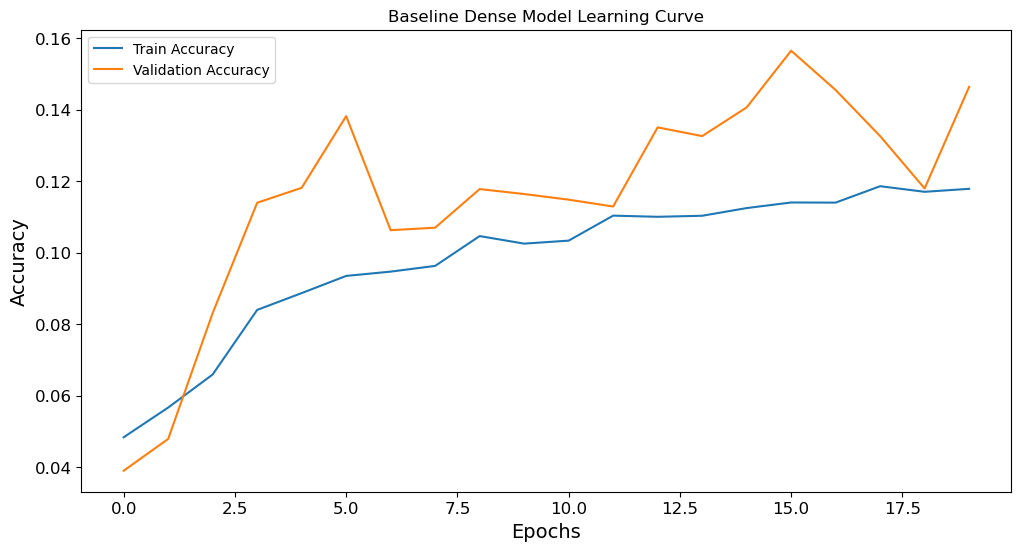

In [12]:
# Plot learning curves for the baseline dense model
plt.figure(figsize=(12, 6))
plt.plot(history_baseline_dense.history['accuracy'], label='Train Accuracy')
plt.plot(history_baseline_dense.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Dense Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 3.2 CNN model

CNN model has 2 convolutional layers (64 and 128 filters) and 2 dense layers (76 and 24 units) that reach the limit of parameters.

In [13]:
# Define the baseline CNN model
def build_baseline_cnn_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(76, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(24, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
# Build the baseline CNN model
baseline_cnn_model = build_baseline_cnn_model()

# Summary of the baseline CNN model
baseline_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_3 (Dense)             (None, 76)               

In [15]:
# Train the baseline CNN model
baseline_cnn_model = build_baseline_cnn_model()
history_baseline_cnn = baseline_cnn_model.fit(
    X_train, y_train_cat,
    epochs=20,
    validation_data=(X_val, y_val_cat),
    batch_size=128,  
    verbose=0
)

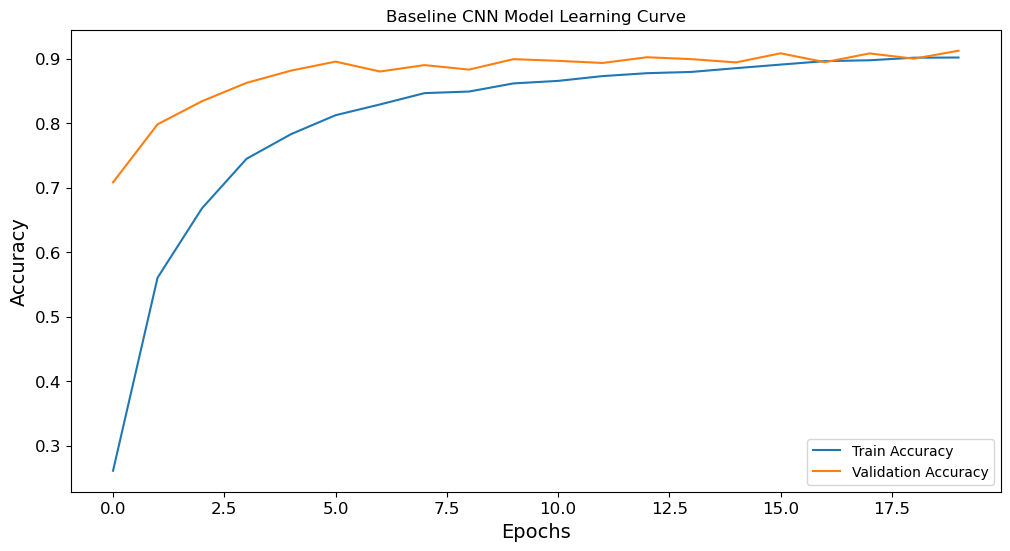

In [16]:
# Plot learning curves for the baseline CNN model
plt.figure(figsize=(12, 6))
plt.plot(history_baseline_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_baseline_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline CNN Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Densly model is underfitting. The performance of CNN model is high, however, it does not meet the requirement. Thus, both models need to be optimised.

## 4. Model Optimisation

There are 3 models that will be optimised: 1 densly connected model and 2 CNN models with different number of layers.

Due to the limitation of the number of executions (50 runs in total), Bayesian Optimisation will be used to optimmise hyper-parameters.

Hyper-parameters that will be optimised includes:
- Number of units in dense layers
- Number of filters in convolutional layers
- Drop rate in dropout layers
- Activation functions
- Learning rates
- Optimizers

### 4.1. Dense model

In [17]:
# Define function to create dense model
def build_dense_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    
    units = hp.Int('units', min_value=64, max_value=256, step=32)
    activation = hp.Choice('dense_activation', values=['elu', 'relu', 'tanh', 'sigmoid'])
    model.add(Dense(units, activation=activation))
    
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(units // 2, activation=activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(24, activation='softmax')) 
    
    learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# Dense Model Tuning
tuner_dense = kt.BayesianOptimization(
    build_dense_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='dense',
    project_name='sign_language_dense'
)

tuner_dense.search(X_train, y_train_cat, epochs=20, validation_data=(X_val, y_val_cat), 
                    batch_size=128, verbose=0)  

# Get the optimal hyperparameters
best_hps_dense = tuner_dense.get_best_hyperparameters(num_trials=1)[0]
print('Best Dense Model Hyperparameters:\n', best_hps_dense.values)

# Build the best dense model
best_dense_model = tuner_dense.hypermodel.build(best_hps_dense)

# Summary of the best dense model
print('Best Dense Model Summary:')
best_dense_model.summary()

# Train the best dense model
history_dense = best_dense_model.fit(X_train, y_train_cat, epochs=20, validation_data=(X_val, y_val_cat), 
                                    batch_size=128, verbose=0)  

Best Dense Model Hyperparameters:
 {'units': 128, 'dense_activation': 'elu', 'dropout_rate': 0.2, 'learning_rate': 0.001}
Best Dense Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               131200    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 24

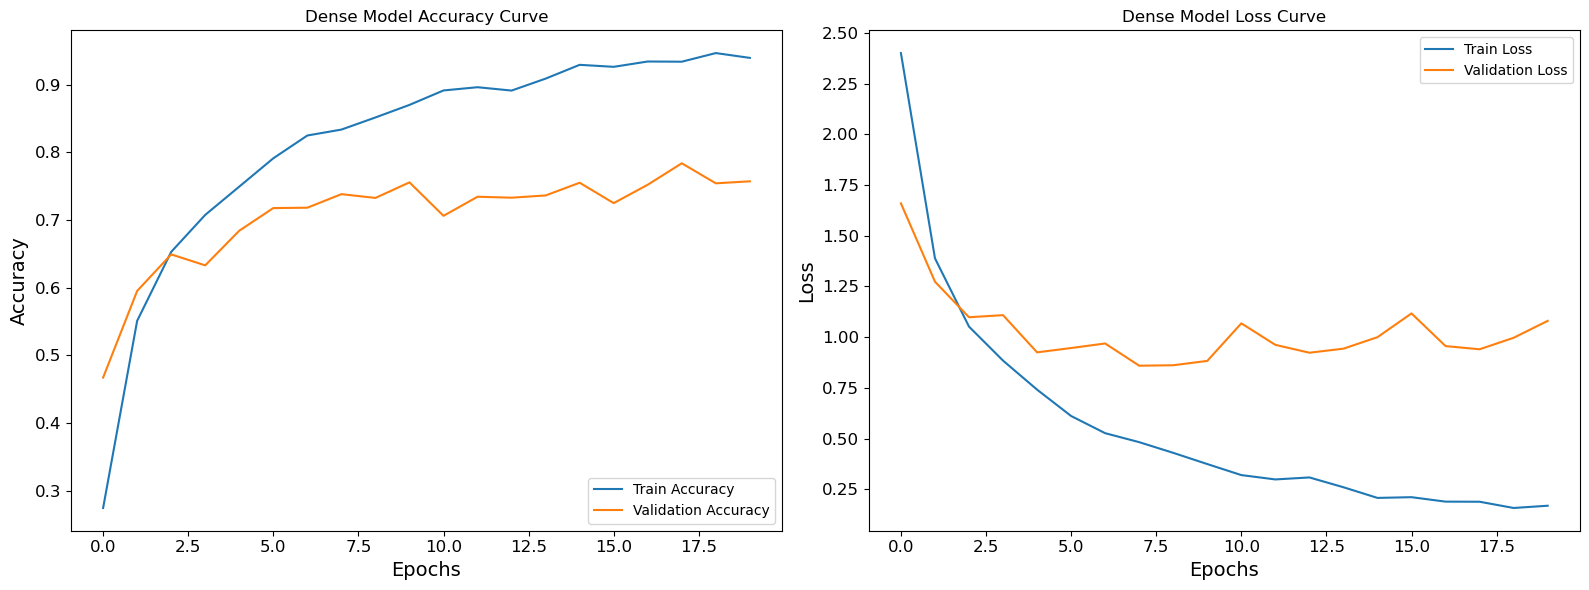

In [50]:
# Plot learning curves for the best Dense model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
ax1.plot(history_dense.history['accuracy'], label='Train Accuracy')
ax1.plot(history_dense.history['val_accuracy'], label='Validation Accuracy')
ax1.yaxis.set_major_locator(MaxNLocator(nbins=9))
ax1.set_title('Dense Model Accuracy Curve')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Loss
ax2.plot(history_dense.history['loss'], label='Train Loss')
ax2.plot(history_dense.history['val_loss'], label='Validation Loss')
ax2.yaxis.set_major_locator(MaxNLocator(nbins=12))
ax2.set_title('Dense Model Loss Curve')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.2. CNN model 1

In [20]:
def build_cnn_model_1(hp):
    model = Sequential()

    filters = hp.Int('filters', min_value=32, max_value=64, step=16)
    activation = hp.Choice('cnn_activation', values=['elu', 'relu', 'tanh', 'sigmoid'])
    model.add(Conv2D(filters, kernel_size=(3, 3), activation=activation, input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    filters_2 = hp.Int('filters_2', min_value=64, max_value=128, step=32)
    model.add(Conv2D(filters_2, kernel_size=(3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    dense_units = hp.Int('dense_units', min_value=48, max_value=84, step=12)
    model.add(Dense(dense_units, activation=activation))
    
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(24, activation='softmax')) 
    
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
# CNN Model Tuning
tuner_cnn_1 = kt.BayesianOptimization(
    build_cnn_model_1,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='cnn_1',
    project_name='sign_language_cnn'
)

tuner_cnn_1.search(X_train, y_train_cat, epochs=20, validation_data=(X_val, y_val_cat), batch_size=128, verbose=0)

# Get the optimal hyperparameters
best_hps_cnn_1 = tuner_cnn_1.get_best_hyperparameters(num_trials=1)[0]
print('Best CNN Model Hyperparameters:\n', best_hps_cnn_1.values)

# Build the best CNN model 1
best_cnn_model_1 = tuner_cnn_1.hypermodel.build(best_hps_cnn_1)

# Summary of the best CNN model 1
print('Best CNN Model 1 Summary:')
best_cnn_model_1.summary()

# Train the best model
history_cnn_1 = best_cnn_model_1.fit(X_train, y_train_cat, epochs=20, validation_data=(X_val, y_val_cat), batch_size=128, verbose=0) 

Best CNN Model Hyperparameters:
 {'filters': 48, 'cnn_activation': 'tanh', 'filters_2': 96, 'dense_units': 84, 'dropout_rate': 0.45, 'learning_rate': 0.001, 'optimizer': 'adam'}
Best CNN Model 1 Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 48)        480       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 48)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 96)        41568     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 96)         0         
 2D)                                                             
                                                

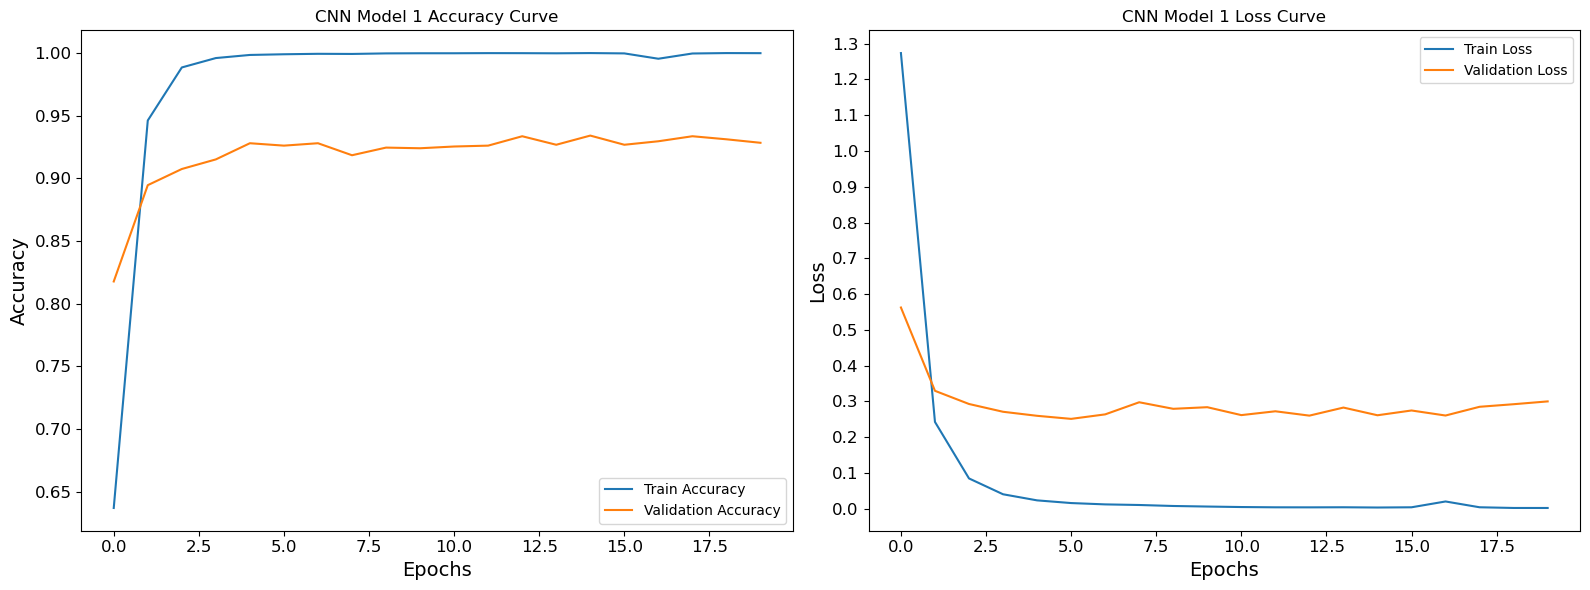

In [51]:
# Plot learning curves for the best CNN model 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
ax1.plot(history_cnn_1.history['accuracy'], label='Train Accuracy')
ax1.plot(history_cnn_1.history['val_accuracy'], label='Validation Accuracy')
ax1.yaxis.set_major_locator(MaxNLocator(nbins=9))
ax1.set_title('CNN Model 1 Accuracy Curve')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Loss
ax2.plot(history_cnn_1.history['loss'], label='Train Loss')
ax2.plot(history_cnn_1.history['val_loss'], label='Validation Loss')
ax2.yaxis.set_major_locator(MaxNLocator(nbins=14))
ax2.set_title('CNN Model 1 Loss Curve')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.3. CNN model 2

Add 1 more convolutional layer and 1 average pooling.

In [23]:
def build_cnn_model_2(hp):
    model = Sequential()

    filters = hp.Int('filters', min_value=16, max_value=64, step=16)
    activation = hp.Choice('cnn_activation', values=['elu', 'relu', 'tanh', 'sigmoid'])
    model.add(Conv2D(filters, kernel_size=(3, 3), activation=activation, input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    filters_2 = hp.Int('filters_2', min_value=32, max_value=128, step=32)
    model.add(Conv2D(filters_2, kernel_size=(3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    filters_3 = hp.Int('filters_3', min_value=64, max_value=256, step=64)
    model.add(Conv2D(filters_3, kernel_size=(3, 3), activation=activation))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    dense_units = hp.Int('dense_units', min_value=48, max_value=96, step=24)
    model.add(Dense(dense_units, activation=activation))
    
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(24, activation='softmax')) 
    
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [24]:
# CNN Model Tuning
tuner_cnn_2 = kt.BayesianOptimization(
    build_cnn_model_2,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='cnn_2',
    project_name='sign_language_cnn'
)

tuner_cnn_2.search(X_train, y_train_cat, epochs=20, validation_data=(X_val, y_val_cat), batch_size=128, verbose=0)

# Get the optimal hyperparameters
best_hps_cnn_2 = tuner_cnn_2.get_best_hyperparameters(num_trials=1)[0]
print('Best CNN Model Hyperparameters:\n', best_hps_cnn_2.values)

# Build the best CNN model 2
best_cnn_model_2 = tuner_cnn_2.hypermodel.build(best_hps_cnn_2)

# Summary of the best CNN model 2
print('Best CNN Model 2 Summary:')
best_cnn_model_2.summary()

# Train the best model
history_cnn_2 = best_cnn_model_2.fit(X_train, y_train_cat, epochs=20, validation_data=(X_val, y_val_cat), batch_size=128, verbose=0) 

Best CNN Model Hyperparameters:
 {'filters': 64, 'cnn_activation': 'relu', 'filters_2': 96, 'filters_3': 128, 'dense_units': 72, 'dropout_rate': 0.35000000000000003, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
Best CNN Model 2 Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 96)        55392     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 96)         0         
 2D)                                                             
            

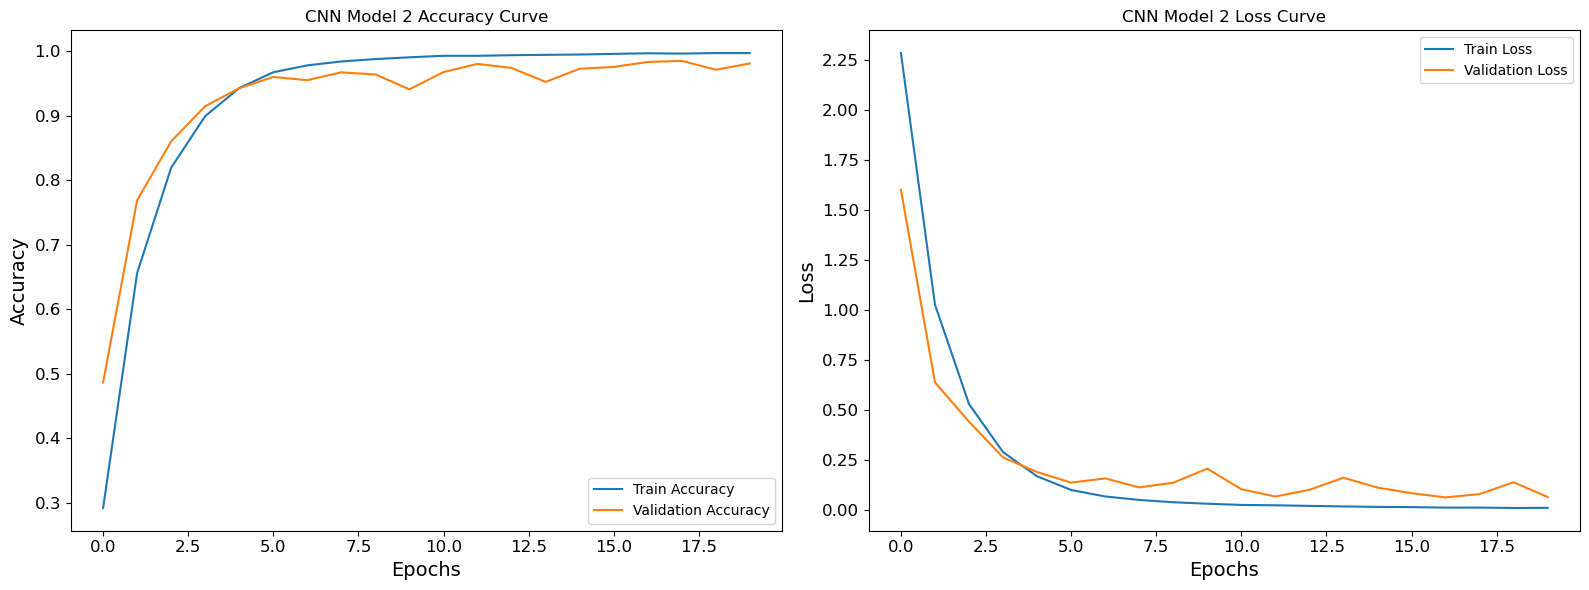

In [52]:
# Plot learning curves for the best CNN model 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
ax1.plot(history_cnn_2.history['accuracy'], label='Train Accuracy')
ax1.plot(history_cnn_2.history['val_accuracy'], label='Validation Accuracy')
ax1.yaxis.set_major_locator(MaxNLocator(nbins=9))
ax1.set_title('CNN Model 2 Accuracy Curve')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Loss
ax2.plot(history_cnn_2.history['loss'], label='Train Loss')
ax2.plot(history_cnn_2.history['val_loss'], label='Validation Loss')
ax2.yaxis.set_major_locator(MaxNLocator(nbins=12))
ax2.set_title('CNN Model 2 Loss Curve')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.4 Evaluate models and choose the best performance

In [26]:
# Evaluate dense model
dense_model_performance = best_dense_model.evaluate(X_val, y_val_cat, verbose=0)
print(f'Dense Model Validation Accuracy: {round(dense_model_performance[1], 2)}')

# Evaluate CNN model 1
cnn_model_1_performance = best_cnn_model_1.evaluate(X_val, y_val_cat, verbose=0)
print(f'CNN Model Validation Accuracy: {round(cnn_model_1_performance[1], 2)}')

# Evaluate CNN model 2
cnn_model_2_performance = best_cnn_model_2.evaluate(X_val, y_val_cat, verbose=0)
print(f'CNN Model Validation Accuracy: {round(cnn_model_2_performance[1], 2)}')

# Choose the best model based on validation accuracy
if cnn_model_1_performance[1] > dense_model_performance[1] and cnn_model_1_performance[1] > cnn_model_2_performance[1]:
    best_model = best_cnn_model_1
    best_model_params = best_hps_cnn_1.values
    best_model_name = 'CNN model 1'
elif cnn_model_2_performance[1] > dense_model_performance[1] and cnn_model_2_performance[1] > cnn_model_1_performance[1]:
    best_model = best_cnn_model_2
    best_model_params = best_hps_cnn_2.values
    best_model_name = 'CNN model 2'
else:
    best_model = best_dense_model
    best_model_params = best_hps_dense.values
    best_model_name = 'Dense'
print(f'Best model: {best_model_name}')
print(f'Best model parameters:\n {best_model_params}')

Dense Model Validation Accuracy: 0.76
CNN Model Validation Accuracy: 0.93
CNN Model Validation Accuracy: 0.98
Best model: CNN model 2
Best model parameters:
 {'filters': 64, 'cnn_activation': 'relu', 'filters_2': 96, 'filters_3': 128, 'dense_units': 72, 'dropout_rate': 0.35000000000000003, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}


## 5. Final results

45/45 [==============================] - 0s 7ms/step


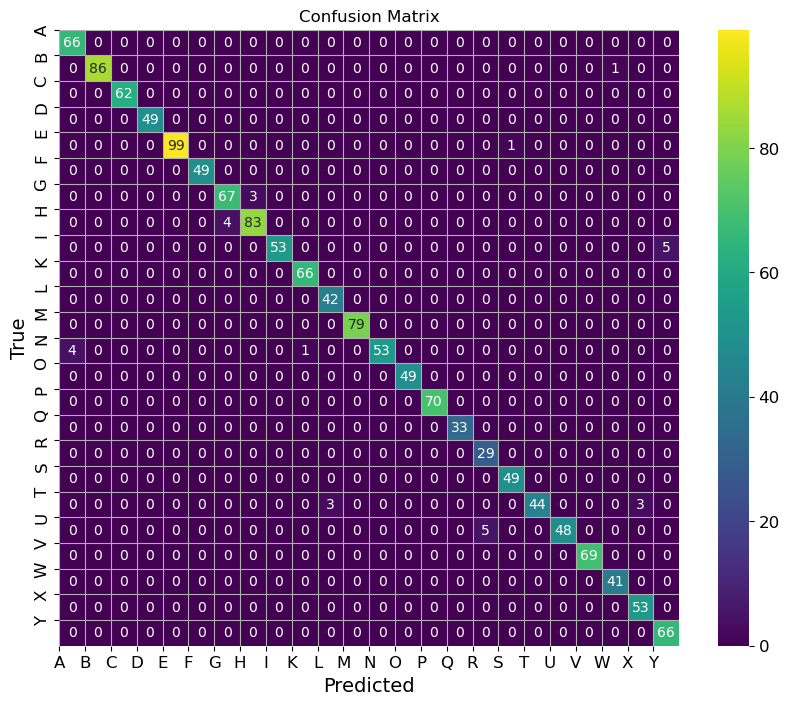

In [67]:
# Predictions
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.xticks(ticks=range(24), labels=np.unique(y_test_alphabet))
plt.ylabel('True')
plt.yticks(ticks=range(24), labels=np.unique(y_test_alphabet))
plt.title('Confusion Matrix')
plt.grid(True)
plt.show()

Mean Accuracy: 0.98
Unbiased Median Accuracy: 1.0
Letter with Highest Individual Accuracy: A - 1.0
Letter with Lowest Individual Accuracy: T - 0.88
Three Most Common Single Types of Errors (True, Predicted, Proportion): [('U', 'R', 0.094), ('I', 'Y', 0.086), ('N', 'A', 0.069)]


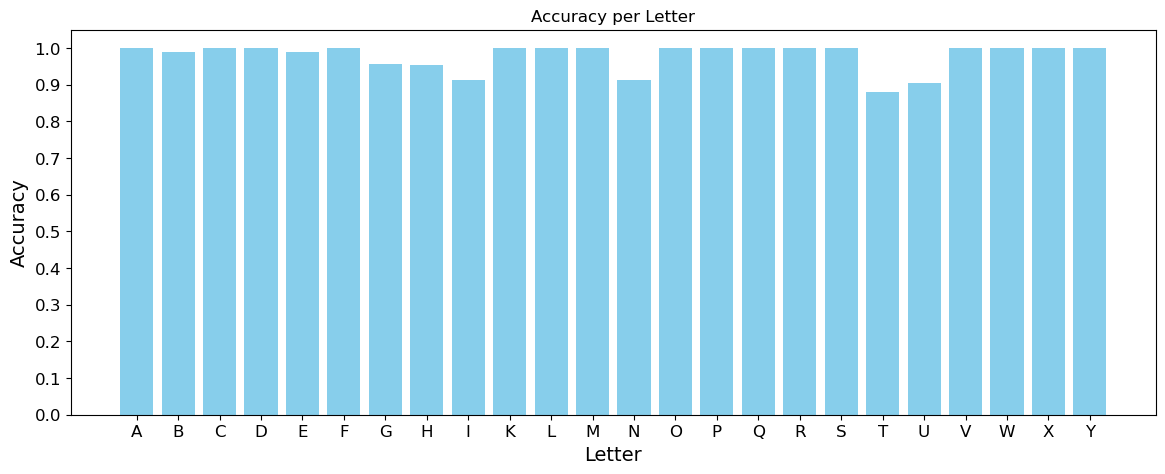

In [79]:
# Calculate accuracy per letter
letters = np.unique(y_test_alphabet)
accuracies = cm.diagonal() / cm.sum(axis=1)
letter_accuracies = {letters[i]: acc for i, acc in enumerate(accuracies)}
print(f'Mean Accuracy: {round(np.mean(accuracies), 2)}')

# Calculate unbiased median accuracy
unbiased_median_accuracy = np.median(accuracies)
print(f"Unbiased Median Accuracy: {unbiased_median_accuracy}")

# Identify highest and lowest accuracy letters
highest_accuracy_letter = max(letter_accuracies.items(), key=lambda x: x[1])
lowest_accuracy_letter = min(letter_accuracies.items(), key=lambda x: x[1])

# Identify the three most common single types of errors
errors_index = [(true, pred) for true, row in enumerate(cm) for pred, count in enumerate(row) if true != pred and count > 0]
errors_proportions = [round(cm[true, pred]/np.sum(cm[true]), 3) for true, pred in errors_index]
errors = list(zip(errors_index, errors_proportions))
sorted_errors = sorted(errors, key=lambda x: x[1], reverse=True)
most_common_errors = [(letters[true], letters[pred], proportion) for (true, pred), proportion in sorted_errors[:3]]

print(f'Letter with Highest Individual Accuracy: {highest_accuracy_letter[0]} - {round(highest_accuracy_letter[1], 2)}')
print(f'Letter with Lowest Individual Accuracy: {lowest_accuracy_letter[0]} - {round(lowest_accuracy_letter[1], 2)}')
print(f'Three Most Common Single Types of Errors (True, Predicted, Proportion): {most_common_errors}')

# Plot the accuracies per letter
plt.figure(figsize=(14, 5))
plt.bar(letter_accuracies.keys(), letter_accuracies.values(), color='skyblue')
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=11))
plt.xlabel('Letter')
plt.ylabel('Accuracy')
plt.title('Accuracy per Letter')
plt.show()

The model meets the desired performance criteria:
- The median accuracy exceeds 94% overall (100%)
- The lowest accuracy for each individual letter is better than 85% (88%)
- The overall mean accuracy is 98%

With the limitation number of runs in optimisation, there are only 20 runs used for optimising the best model (CNN model 2). Therefore, further fine-tuning with minor model adjustments and experimenting more runs might enhance the performance for the letter with the lowest accuracy.